Problem 5:
Adding additional features to problem number 4

Load in the training and test images.

In [0]:
# Harrison Black
# HA435377
# CAP 5610
# UCF Spring 2019

# Problem 5
# Add features to problem 4

import tensorflow as tf
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from keras import models

mnist = tf.keras.datasets.mnist
(training_imgs, training_labels), (test_imgs_og, test_labels) = mnist.load_data()
number_of_imgs, num_rows, num_columns = training_imgs.shape

training_imgs = (training_imgs.reshape(number_of_imgs, num_rows * num_columns, 1)).astype('float32') / 255
test_imgs = (test_imgs_og.reshape(len(test_imgs_og), num_rows * num_columns, 1)).astype('float32') / 255

Functions for finding features and concatenating them to the end of the image array.
Finds number of white regions for a digit, the digit width, and the digit height.

In [7]:
# Find the number of unique regions, the width, and the height of a given digit
def get_features(img):
  
  # Empty list to store features
  features = []
  
  # Round all grey values
  img = np.around(img)
  
  # Value of previous pixel
  prev_pixel = 0
  
  # Current region
  region_number = 1
  
  # Zeros in the region array signify black pixels once comleted
  region_array = np.full_like(img, 0)
  
  # Values to help determine the width of a digit
  first_in_row = True
  first_black_pixel_in_row = 0
  last_black_pixel_in_row = 0
  longest_range = 0
  
  # Values to help determine height
  top_pixel = 0
  bottom_pixel = 0
  found_first = False
  
  # NOTE: Below both the unique number of regions,the width and the height are found in the same loop
  #       This helps to speed up run time
  
  # Go through each pixel
  for pixel in range(len(img)):
    
    # Labeling regions at start of loop
    
    # Only count on white pixels
    if img[pixel] == 0:
      region_array[pixel] = region_number
      
    # If pixel goes from white to black, region_number += 1
    elif img[pixel] == 1 and prev_pixel == 0:
      region_number += 1

    # Set prev pixel to current pixel and loop
    prev_pixel = img[pixel]
    
    # Determining width and height for the rest of the loop
    # To account for width, keep track of the first black pixel in a row and the last black pixel in a row. The longest span is the width.
    # To account for height, go through the array and mark the first an last black pixel
    
    # If we are in a new row
    if pixel % 28 == 0:
    
      # Determine if the previous row had a larger width than the current largest width
      if last_black_pixel_in_row - first_black_pixel_in_row > longest_range:
        longest_range = last_black_pixel_in_row - first_black_pixel_in_row

      # Reset for new row
      first_black_pixel_in_row = 0
      last_black_pixel_in_row = 0
      first_in_row = True
    
    # If we found the first black pixel
    if img[pixel] == 1 and first_in_row:
      first_black_pixel_in_row = pixel % 28
      first_in_row = False

    # If a black pixel
    if img[pixel] == 1:
      last_black_pixel_in_row = pixel % 28
      bottom_pixel = pixel
      
    if img[pixel] == 1 and not found_first:
      top_pixel = pixel
      found_first = True

  # Finish determining unique regions
  # Loop through again to join touching regions
  for pixel in range(len(img)):
    
    # Don't go out of bounds
    if(pixel + 28 < len(img)):
      
      # Each row is 28 long. If you skip ahead 28 pixels you are looking at the next row 
      # If two non white pixels in different rows are touching, they are in the same region
      if(region_array[pixel] != region_array[pixel + 28] and region_array[pixel] != 0 and region_array[pixel + 28] != 0):
        region_array[region_array == region_array[pixel + 28]] = region_array[pixel]
        
  midline = num_columns // 2

  # Return the number of unique values in the region_array excluding the value for black pixels (0)#   print(np.unique(region_array) ) 
  number_of_regions = len(np.unique(region_array)) - 1
  
  # The width is the longest range of black pixels found
  width = longest_range
  
  # The height is the distance between the first black pixel found and the last black pixel found minus their distance to the midline of the picture
  height = ((bottom_pixel - top_pixel) - abs(midline - (top_pixel % 28)) - abs(midline - (bottom_pixel % 28))) / 28
  
  features.append(number_of_regions)
  features.append(width)
  features.append(height)

  return features

# Append the addition features to the end of each image
def append_features(imgs):
  appended_imgs = []
  for i in range(len(imgs)):
    features = np.array(get_features(imgs[i]))
    features = features.reshape(features.size, 1)
    appended_imgs.append(np.concatenate([imgs[i], features]))
  return appended_imgs

appended_training_imgs = append_features(training_imgs)
appended_test_imgs = append_features(test_imgs)
print("Appending completed")

Appending completed


Train the model using Keras and determine and display it's overall loss and accuracy.

In [20]:
# Train the model using Keras
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(np.array(appended_training_imgs), training_labels, epochs=3)
loss_value, accuracy_value = model.evaluate(np.array(appended_test_imgs), test_labels)

print("\nOverall model performance")
print("Loss value: ", loss_value, "\nModel accuracy: ", accuracy_value)

Epoch 1/3
60000/60000 [==============================] - 3s 44us/sample - loss: 0.6827 - acc: 0.8292
Epoch 2/3
60000/60000 [==============================] - 3s 42us/sample - loss: 0.3777 - acc: 0.9022
Epoch 3/3
10000/10000 [==============================] - 0s 31us/sample - loss: 0.2946 - acc: 0.9204

Overall model performance
Loss value:  0.29463275770545005 
Model accuracy:  0.9204


Show an example prediction and display feature data.


Example prediction: 


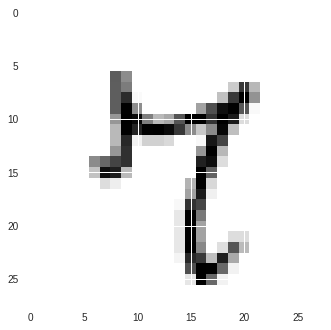

Actual number:  7
Predicted number:  7
Number of white regions:  1 
Digit width:  12 
Digit height:  21.0


In [21]:
# Seed and create random number to test a random image
np.random.seed()
test_index = np.random.randint(0, len(test_imgs), size=None)

print("\nExample prediction: ")
plt.imshow(test_imgs_og[test_index], cmap = plt.cm.binary)
plt.show()

example_digit = np.array(appended_test_imgs[test_index])
example_prediction = model.predict([appended_test_imgs])
example_features = get_features(appended_test_imgs[test_index])

print("Actual number: ", test_labels[test_index])
print("Predicted number: ", np.argmax(example_prediction[test_index]))
print("Number of white regions: ", example_features[0], "\nDigit width: ", example_features[1], "\nDigit height: ", example_features[2])
